In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from tqdm import trange
import numpy as np
import re
from wordcloud import WordCloud

In [2]:
df = pd.read_excel("C:/Users/user/Desktop/AS3面試資料_美妝唇彩.xlsx")
df.head()

,監測主題,標題,內容,來源,來源網站,主文/回文,發佈時間,討論串總則數,點閱數/按讚數,分享/轉貼數/評級,...,FB_哈,FB_哇,FB_嗚,FB_怒,作者,正面強度,負面強度,中立強度,情緒標記,原始連結
0,美妝唇彩,32色''植村秀無色限唇膏''唇部試色??超多土色#MLBB Shu uemura Lips...,上次站在植村秀櫃前挑顏色挑到懷疑人生感謝你的試色影片??辛苦了??,社群網站,Youtube 頻道 > SARAH's MACUP,回文67,2021/03/31 23:59:47,105,10535,0,...,0,0,0,0,李佩容,1.9,0.3,97.8,中立,http://www.youtube.com/watch?v=5be9ZUpmpSE
1,美妝唇彩,32色''植村秀無色限唇膏''唇部試色??超多土色#MLBB Shu uemura Lips...,辛苦了但能一直盯著Sarah的嘴唇看真的好療癒,社群網站,Youtube 頻道 > SARAH's MACUP,回文66,2021/03/31 23:59:36,105,10535,0,...,0,0,0,0,594LOE,99.9,0.0,0.1,正面,http://www.youtube.com/watch?v=5be9ZUpmpSE
2,美妝唇彩,.想到開架唇膏就會想到很經典的#媚比琳⠀ #極綻色絲絨霧光唇膏系列⠀這次新...,500好好看??????,社群網站,Instagram > ???????? 柔伊,回文74,2021/03/31 23:59:25,89,1157,0,...,0,0,0,0,zzooee_1109,99.9,0.0,0.1,正面,https://www.instagram.com/p/CM_bPv8HoYV
3,美妝唇彩,用過@toocoolforschool_tw才會知道他們的質感有多驚人可...,用過@toocoolforschool_tw才會知道他們的質感有多驚人可以在韓妝市場一直當女...,社群網站,Instagram > 大魚,主文,2021/03/31 23:54:51,1,229,0,...,0,0,0,0,imfiishy,99.9,0.0,0.1,正面,https://www.instagram.com/p/CNFsELqlZLw
4,美妝唇彩,YSL唇膏真的女孩們必備欸不管是包裝還是超美的顏色或是親起來的味道完全都是...,122超美??,社群網站,Instagram > 安安??,回文171,2021/03/31 23:50:08,174,0,0,...,0,0,0,0,bbbb0218,99.9,0.0,0.1,正面,https://www.instagram.com/p/CM_88Z5rnEm


In [3]:
len(df.標題.unique())

3746

In [4]:
df.來源網站.value_counts()

Facebook粉絲團 > 邵庭           3790
校園聊天-Dcard > 美妝            3309
Facebook粉絲團 > 許麻瓜           990
Ptt > MakeUp                746
Facebook粉絲團 > FreshO2       513
                           ... 
Instagram > Pinkoi            1
Facebook粉絲團 > 超人氣粉絲團聯盟        1
Facebook粉絲團 > 胡忠信粉絲讚          1
Instagram > huahua            1
Facebook粉絲團 > GU Taiwan       1
Name: 來源網站, Length: 1426, dtype: int64

## 回文時段

In [5]:
print(f"發佈時間範圍: {df.發佈時間.min()} - {df.發佈時間.max()}")

發佈時間範圍: 2021/03/01 00:00:00 - 2021/03/31 23:59:47


<ipython-input-90-540f7fb4eaa5>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[str(x) for x in range(24)])


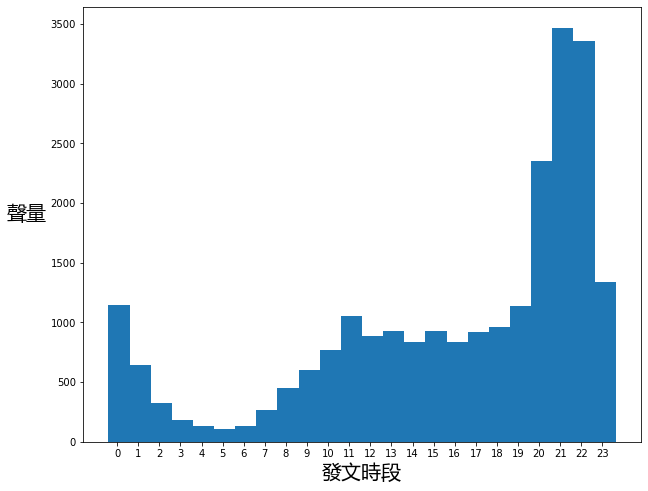

In [90]:
f,ax=plt.subplots(1,1,figsize=(10,8))
x_ticks = [x*(22/23)+0.4 for x in range(24)]
ax.set_xticklabels(labels=[str(x) for x in range(24)])
ax.hist(df.發佈時間.apply(lambda x: int(re.compile(r'\s(\d*):').search(x).group()[1:3])), bins=24)
ax.set_xticks(ticks=x_ticks)
font_label = FontProperties(fname="msyh.ttf", size=20)
# 改變ticks字體
h = ax.set_ylabel("聲量",font=font_label)
# 旋轉ylabel和設定位置
h.set_rotation(0)
ax.yaxis.set_label_coords(-0.1,0.5)
ax.set_xlabel("發文時段",font=font_label)
plt.show()

In [ ]:
ax.plot([x for x in range(24)], df.發佈時間.apply(lambda x: int(re.compile(r'\s(\d*):').search(x).group()[1:3])))

In [98]:
df_time_freq = pd.DataFrame(df.發佈時間.apply(lambda x: int(re.compile(r'\s(\d*):').search(x).group()[1:3])).value_counts()).sort_index()

<ipython-input-244-69bad2f092c7>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[str(x) for x in range(24)])


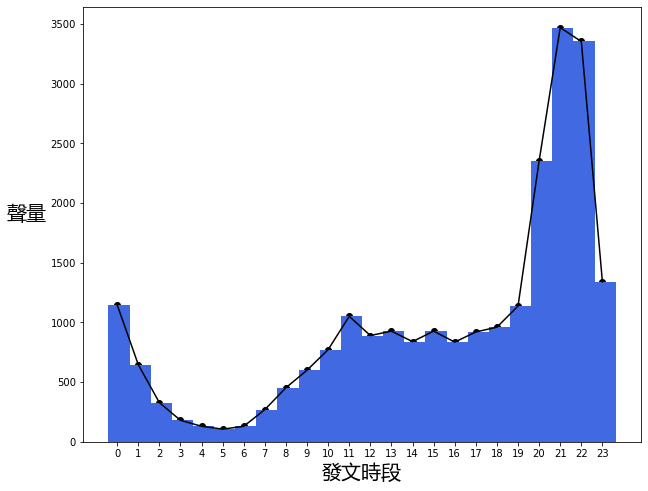

In [244]:
f,ax=plt.subplots(1,1,figsize=(10,8))
x_ticks = [x*(22/23)+0.4 for x in range(24)]
ax.set_xticklabels(labels=[str(x) for x in range(24)])
ax.hist(df.發佈時間.apply(lambda x: int(re.compile(r'\s(\d*):').search(x).group()[1:3])), bins=24, color="royalblue")
ax.scatter(x_ticks, df_time_freq.發佈時間, color="k")
ax.plot(x_ticks, df_time_freq.發佈時間, color="k")
ax.set_xticks(ticks=x_ticks)
font_label = FontProperties(fname="msyh.ttf", size=20)
# 改變ticks字體
h = ax.set_ylabel("聲量",font=font_label)
# 旋轉ylabel和設定位置
h.set_rotation(0)
ax.yaxis.set_label_coords(-0.1,0.5)
ax.set_xlabel("發文時段",font=font_label)
plt.show()

In [248]:
fig = ax.get_figure()
fig.savefig('C:/Users/user/Desktop/碩士後/履歷/意藍二階面試/發文時段.png')

In [ ]:
f,ax=plt.subplots(1,1,figsize=(10,8))
x_ticks = [x*(22/23)+0.4 for x in range(24)]
ax.set_xticklabels(labels=[str(x) for x in range(24)])
ax.scatter([x for x in range(24)], df_time_freq.發佈時間, color="k")
ax.plot([x for x in range(24)], df_time_freq.發佈時間, color="k")
ax.set_xticks(ticks=x_ticks)
font_label = FontProperties(fname="msyh.ttf", size=20)
# 改變ticks字體
h = ax.set_ylabel("聲量",font=font_label)
# 旋轉ylabel和設定位置
h.set_rotation(0)
ax.yaxis.set_label_coords(-0.1,0.5)
ax.set_xlabel("發文時段",font=font_label)
plt.show()

## 好感度

In [306]:
sentiment_ratio = {}
sentiment_ratio["標題"] = []
sentiment_ratio["聲量"] = []
sentiment_ratio["正面情緒"] = []
sentiment_ratio["負面情緒"] = []
sentiment_ratio["情緒正面比例"] = []
sentiment_ratio["情緒正負比"] = []
source_list = df.來源網站.unique()
for i in trange(len(source_list)):
    good = len(df[(df.來源網站==source_list[i])&(df.情緒標記=="正面")])
    bad = len(df[(df.來源網站==source_list[i])&(df.情緒標記=="負面")])
    sentiment_ratio["標題"].append(source_list[i])
    sentiment_ratio["聲量"].append(len(df[(df.來源網站==source_list[i])]))
    sentiment_ratio["正面情緒"].append(good)
    sentiment_ratio["負面情緒"].append(bad)
    sentiment_ratio["情緒正面比例"].append(good/len(df[df.來源網站==source_list[i]]))
    if bad != 0:
        sentiment_ratio["情緒正負比"].append(good/bad)
    else:
        sentiment_ratio["情緒正負比"].append(good)

100%|██████████████████████████████████████| 1426/1426 [00:34<00:00, 41.58it/s]


In [321]:
df_sentiment_ratio = pd.DataFrame(sentiment_ratio)
df_sentiment_ratio.sort_values(by=["聲量"],ascending=False).head()

,標題,聲量,正面情緒,負面情緒,情緒正面比例,情緒正負比
115,Facebook粉絲團 > 邵庭,3790,1489,208,0.392876,7.158654
1363,校園聊天-Dcard > 美妝,3309,1197,460,0.361741,2.602174
1045,Facebook粉絲團 > 許麻瓜,990,161,19,0.162626,8.473684
1368,Ptt > MakeUp,746,289,78,0.387399,3.705128
33,Facebook粉絲團 > FreshO2,513,260,3,0.506823,86.666667


In [322]:
df_sentiment_ratio = df_sentiment_ratio.sort_values(by=["聲量"],ascending=False).reset_index().loc[:20,:].sort_values(by=["情緒正負比"],ascending=False)
df_sentiment_ratio.to_excel('C:/Users/user/Desktop/碩士後/履歷/意藍二階面試/情緒標記.xlsx')

## 文字雲

In [8]:
df_frequency = pd.read_excel("C:/Users/user/Desktop/AS3面試資料_美妝唇彩.xlsx", sheet_name = "斷詞")
df_frequency.head()

,詞,詞頻,文章數
0,唇膏,14766,12344
1,口紅,6229,5612
2,唇釉,5231,4274
3,無色限,3779,3770
4,酷甜風,3733,3731


In [192]:
wordcloud_dict = {}
for i in trange(len(df_frequency)):
    wordcloud_dict[str(df_frequency.詞.iloc[i])] = df_frequency.詞頻.iloc[i]
stopwords_list = ["試色試起來美呆","真的","覺得","還是","分享婚後還是打理","玩遊戲抽免單送","起來","這個","熱銷萬支感應換色","最懂好閨蜜再度","以下為轉貼文章","隻貓"]
cloud = WordCloud(font_path="msyh.ttf", max_words=50, width=1024, height=768, colormap="winter", background_color="snow", stopwords=stopwords_list).generate_from_frequencies(wordcloud_dict)

100%|██████████████████████████████████| 16891/16891 [00:03<00:00, 5603.86it/s]


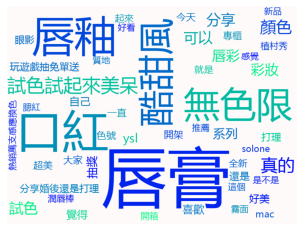

In [193]:
import matplotlib.pyplot as plt
plt.imshow(cloud)
plt.axis("off")
plt.show()

In [249]:
cloud.to_file('C:/Users/user/Desktop/碩士後/履歷/意藍二階面試/文字雲.png')

## 品牌聲量

In [210]:
name_list = ["ysl","mac","植村秀","solone","heme", "romand", "dior",  "chanel", "bobbi", "herm", "愛馬仕", "herme", "hermes"]
frequecy_list = [df_frequency[df_frequency.詞==x].文章數.iloc[0] for x in name_list]
print(frequecy_list)

[1147, 666, 632, 472, 455, 319, 229, 151, 179, 231, 164, 3, 86]


In [211]:
frequecy_list[-4] = sum(frequecy_list[-4:])
frequecy_list = frequecy_list[:-3]
name_list = ["YSL","M.A.C","植村秀","Solone","heme","rom&nd","Dior","CHANEL","Bobbi Brown","Hermès"]

In [212]:
df_brand = pd.DataFrame({"品牌":name_list,"聲量":frequecy_list}).sort_values(by=["聲量"],ascending=False)
df_brand.head()

,品牌,聲量
0,YSL,1147
1,M.A.C,666
2,植村秀,632
9,Hermès,484
3,Solone,472


In [276]:
x_value = df_brand.聲量.to_list()
x_value.reverse()
y_value = df_brand.品牌.to_list()
y_value.reverse()

<ipython-input-275-1cda3071dec1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=y_value,font=font)


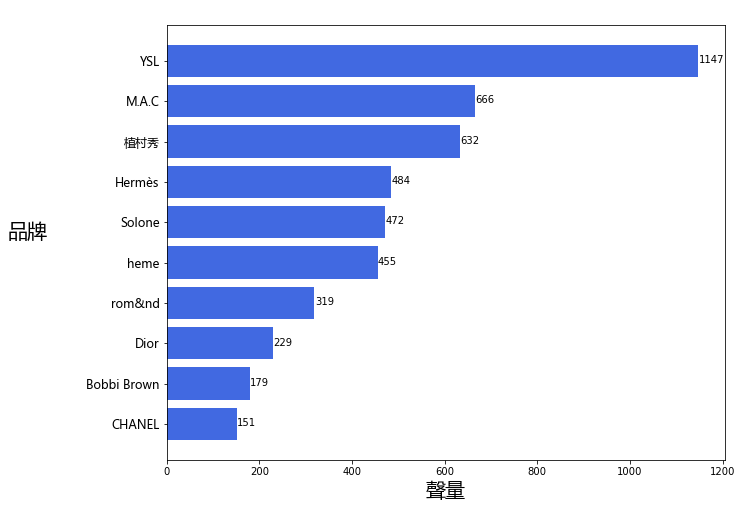

In [277]:
ax = plot_table(y_value,x_value," ",-0.25,"品牌")

In [278]:
fig = ax.get_figure()
fig.savefig('C:/Users/user/Desktop/碩士後/履歷/意藍二階面試/聲量_品牌.png')

## 回應比

In [12]:
reaction_ratio = {}
reaction_ratio["來源網站"] = []
reaction_ratio["主文"] = []
reaction_ratio["回文"] = []
reaction_ratio["回應比"] = []
reaction_list = df.來源網站.unique()
for i in trange(len(reaction_list)):
    reaction_ratio["來源網站"].append(reaction_list[i])
    post = len(df[(df["主文/回文"] == "主文")&(df["來源網站"]==reaction_list[i])])
    reply = len(df[(df["主文/回文"] != "主文")&(df["來源網站"]==reaction_list[i])])
    reaction_ratio["主文"].append(post)
    reaction_ratio["回文"].append(reply)
    if post != 0:
        reaction_ratio["回應比"].append(reply/post)
    else:
        reaction_ratio["回應比"].append(0)

100%|██████████████████████████████████████| 1426/1426 [00:17<00:00, 80.85it/s]


In [13]:
df_reaction = pd.DataFrame(reaction_ratio)
df_reaction.sort_values(by=["回應比"], ascending=False).head()

,來源網站,主文,回文,回應比
115,Facebook粉絲團 > 邵庭,2,3788,1894.0
1045,Facebook粉絲團 > 許麻瓜,1,989,989.0
122,Facebook公開社團 > 爆廢1公社,2,403,201.5
91,Facebook粉絲團 > 許允樂的老兵魂,2,368,184.0
635,Instagram > 徐琁 COS,1,183,183.0


In [45]:
df_reaction.head()

,來源網站,主文,回文,回應比
0,Youtube 頻道 > SARAH's MACUP,0,274,0.0
1,Instagram > ???????? 柔伊,1,74,74.0
2,Instagram > 大魚,1,0,0.0
3,Instagram > 安安??,2,176,88.0
4,Instagram > M•A•C Cosmetics Taiwan,35,84,2.4


In [275]:
def plot_table(y_value,x_value,title,y_lable_xPos,y_label_name,figsize=(10,8)):
#     Index = [x[0] for x in table.index]
#     Index.reverse()
    f,ax=plt.subplots(1,1,figsize=figsize)
    ax.barh(y=y_value, width=x_value, color="royalblue")
    # 設定字體和文字大小
    font = FontProperties(fname="msyh.ttf", size=12)
    font_label = FontProperties(fname="msyh.ttf", size=20)
    font_title = FontProperties(fname="msyh.ttf", size=15)
    # 改變ticks字體
    ax.set_yticklabels(labels=y_value,font=font)
    h = ax.set_ylabel(y_label_name,font=font_label)
    # 旋轉ylabel和設定位置
    h.set_rotation(0)
    ax.yaxis.set_label_coords(y_lable_xPos,0.5)
    ax.set_xlabel("聲量",font=font_label)
#     for rowNum,row in enumerate(table):
#         rowNum = len(table) - rowNum
#         xpos = 0
#         xpos += row
#         ax.text(xpos + 1, rowNum-1.05, str(row), color='black')
    rowNum = [x+1 for x in range(len(x_value))]
    for rowNum,row in zip(rowNum,x_value):
        xpos = 0
        xpos += row
        ax.text(xpos + 1, rowNum-1.05, str(round(row,2)), color='black')
    # ax.text(-1,len(table),"test")
    ax.set_title(title,font=font_title)
    plt.show()
    return ax

In [279]:
df_reaction_sort = df_reaction.sort_values(by=["回應比"], ascending=False)
x_value = df_reaction_sort.回應比.iloc[:10].to_list()
x_value.reverse()
y_value = df_reaction_sort.來源網站.iloc[:10].to_list()
y_value.reverse()
y_value = [x.replace("?","") for x in y_value]

<ipython-input-275-1cda3071dec1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=y_value,font=font)


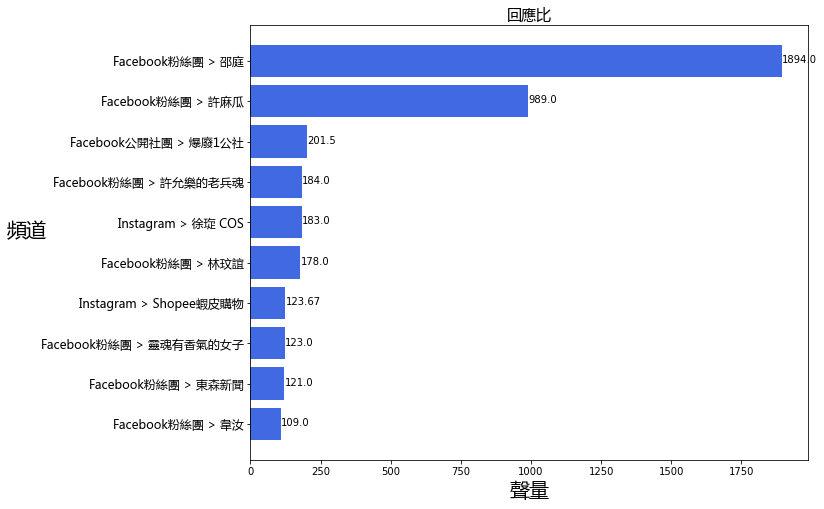

In [280]:
ax = plot_table(y_value,x_value,"回應比",-0.4,"頻道")

In [281]:
fig = ax.get_figure()
fig.savefig('C:/Users/user/Desktop/碩士後/履歷/意藍二階面試/回應比.png')

## 資料整理

In [34]:
df["標題與來源"] = df.apply(lambda x: x.標題 + "_" + x.來源網站, axis=1)

overall = {}
overall["標題"] = []
overall["來源"] = []
overall["來源網站"] = []
overall["討論串總則數"] = []
overall["討論串總抓取則數"] = []
overall["正面數"] = []
overall["負面數"] = []
overall["正面比例"] = []
for i in trange(len(df.標題與來源.unique())):
    overall["標題"].append(df[df.標題與來源==df.標題與來源.unique()[i]].標題.iloc[0])
    overall["來源"].append(df[df.標題與來源==df.標題與來源.unique()[i]].來源.iloc[0])
    overall["來源網站"].append(df[df.標題與來源==df.標題與來源.unique()[i]].來源網站.iloc[0])
    overall["討論串總則數"].append(df[df.標題與來源==df.標題與來源.unique()[i]]["討論串總則數"].iloc[0])
    overall["討論串總抓取則數"].append(len(df[df.標題與來源==df.標題與來源.unique()[i]]))
    overall["正面數"].append(len(df[(df.標題與來源==df.標題與來源.unique()[i])&(df.情緒標記=="正面")]))
    overall["負面數"].append(len(df[(df.標題與來源==df.標題與來源.unique()[i])&(df.情緒標記=="負面")]))
    overall["正面比例"].append(len(df[(df.標題與來源==df.標題與來源.unique()[i])&(df.情緒標記=="正面")])/len(df[df.標題與來源==df.標題與來源.unique()[i]]))

100%|██████████████████████████████████████| 3922/3922 [10:47<00:00,  6.06it/s]


In [35]:
df_overall = pd.DataFrame(overall)

In [36]:
df_overall["平台"] = df_overall.來源網站.apply(lambda x: x.split(" > ")[0])
df_overall["頻道"] = df_overall.來源網站.apply(lambda x: x.split(" > ")[1].replace("?",""))
# 若無負面評論則除以1
df_overall["情緒正負比"] = df_overall.apply(lambda x: x.正面數/x.負面數 if x.負面數!=0 else x.正面數, axis=1)

In [37]:
df_overall.head()

,標題,來源,來源網站,討論串總則數,討論串總抓取則數,正面數,負面數,正面比例,平台,頻道,情緒正負比
0,32色''植村秀無色限唇膏''唇部試色??超多土色#MLBB Shu uemura Lips...,社群網站,Youtube 頻道 > SARAH's MACUP,105,67,28,6,0.417910,Youtube 頻道,SARAH's MACUP,4.666667
1,.想到開架唇膏就會想到很經典的#媚比琳⠀ #極綻色絲絨霧光唇膏系列⠀這次新...,社群網站,Instagram > ???????? 柔伊,89,75,59,1,0.786667,Instagram,柔伊,59.000000
2,用過@toocoolforschool_tw才會知道他們的質感有多驚人可...,社群網站,Instagram > 大魚,1,1,1,0,1.000000,Instagram,大魚,1.000000
3,YSL唇膏真的女孩們必備欸不管是包裝還是超美的顏色或是親起來的味道完全都是...,社群網站,Instagram > 安安??,174,172,82,0,0.476744,Instagram,安安,82.000000
4,深深著迷捨不得移開雙眼??﻿ @lalalalisa_m唇上#特潤霧光唇釉...,社群網站,Instagram > M•A•C Cosmetics Taiwan,60,49,6,0,0.122449,Instagram,M•A•C Cosmetics Taiwan,6.000000


In [44]:
# 有一些沒對起來
# 同個標題應該都要來自同個來源網站，是否有誤植? (或是剛剛好標題相同?)
df_overall[df_overall.來源網站=="Facebook粉絲團 > FreshO2"].討論串總抓取則數.sum()

513

In [40]:
df_overall[df_overall.來源網站=="Facebook粉絲團 > 邵庭"].討論串總抓取則數.sum()

3790

In [33]:
# 還真的有標題相同......
len(df.apply(lambda x: x.標題 + "_" + x.來源網站, axis=1).unique())

3922

## 視覺化 (失敗區)

In [ ]:
def plot_popularity_by_cat(table,title,y_lable_xPos):
#     table = pd.DataFrame(YT_dict).value_counts()[:15]
    Index = [x[0] for x in table.index]
    Index.reverse()
    f,ax=plt.subplots(1,1,figsize=(10,8))
    ax.barh(y=Index, width=np.flip(table.values),color="r")
    # 設定字體和文字大小
    font = FontProperties(fname="msyh.ttf", size=12)
    font_label = FontProperties(fname="msyh.ttf", size=20)
    font_title = FontProperties(fname="msyh.ttf", size=15)
    # 改變ticks字體
    ax.set_yticklabels(labels=Index,font=font)
    h = ax.set_ylabel("平台",font=font_label)
    # 旋轉ylabel和設定位置
    h.set_rotation(0)
    ax.yaxis.set_label_coords(y_lable_xPos,0.5)
    ax.set_xlabel("聲量",font=font_label)
    for rowNum,row in enumerate(table):
        rowNum = len(table) - rowNum
        xpos = 0
        xpos += row
        ax.text(xpos + 1, rowNum-1.05, str(row), color='black')
    # ax.text(-1,len(table),"test")
    ax.set_title(title,font=font_title)
    plt.show()

In [127]:
df_overall[df_overall.平台=="Facebook粉絲團"].來源網站.unique()

array(['Facebook粉絲團 > PopUlzzang 波波妝漂亮', 'Facebook粉絲團 > Beauty美人圈',
       'Facebook粉絲團 > Oguma【水美媒噴年輕】幸福農場',
       'Facebook粉絲團 > 【LOOKin】美人時髦話題網。看見女性新時尚', 'Facebook粉絲團 > 噪咖',
       'Facebook粉絲團 > 米可白', 'Facebook粉絲團 > MI MING MART 彌明生活百貨',
       'Facebook粉絲團 > EVER RICH 昇恆昌宅配網&免稅購物網', 'Facebook粉絲團 > 順發+',
       'Facebook粉絲團 > 張本渝', 'Facebook粉絲團 > 卡比日報 Kabigon Daily',
       'Facebook粉絲團 > FreshO2',
       'Facebook粉絲團 > Cindy x Make Up x Shopping',
       'Facebook粉絲團 > Kevin老師', 'Facebook粉絲團 > 李佳歡 KarFun',
       'Facebook粉絲團 > 洪文安 Ann Hong', 'Facebook粉絲團 > 雨揚樂活家族',
       'Facebook粉絲團 > Mr. 布雷蕭', 'Facebook粉絲團 > 鍾欣怡 Cathy Chung',
       'Facebook粉絲團 > CityColor', 'Facebook粉絲團 > Clio珂莉奧 Taiwan',
       'Facebook粉絲團 > Sandy & Mandy', 'Facebook粉絲團 > 靈魂有香氣的女子',
       'Facebook粉絲團 > 靠北工程師', 'Facebook粉絲團 > Gjun-就愛嗑英文吐司',
       'Facebook粉絲團 > Choc 恰女生', 'Facebook粉絲團 > LOOKin小姐搞事情',
       'Facebook粉絲團 > udn.com 聯合新聞網', 'Facebook粉絲團 > 麥兜小米的心情雜記',
       'Facebook粉絲團 > Mdmmd.', 'Faceboo

In [ ]:
plot_table(y_value,x_value,"回應比",-0.4)

In [59]:
def test_match_word(test_string,cat,require_return=False):
    match_list = []
    for i in trange(len(df[cat])):
        if test_string in str(df[cat].iloc[i]):
            match_list.append(df[cat].iloc[i])
    print(f"There are {len(match_list)} matches.")
    print(match_list[:10])
    if require_return:
        return match_list

In [60]:
IG_matched = test_match_word("Instagram", "來源網站",True)
IG_dict = {"來源網站":IG_matched}
pd.DataFrame(IG_dict).value_counts()[:20]

100%|█████████████████████████████████| 23762/23762 [00:02<00:00, 10795.38it/s]


There are 4895 matches.
['Instagram > ???????? 柔伊', 'Instagram > 大魚', 'Instagram > 安安??', 'Instagram > M•A•C Cosmetics Taiwan', 'Instagram > 妮娜Ninalin', 'Instagram > 安安??', 'Instagram > 安安??', 'Instagram > 湯 Tang', 'Instagram > 黃亭恩TN', 'Instagram > 妮娜Ninalin']


來源網站                              
Instagram > Shopee蝦皮購物                374
Instagram > 彩妝控妮妮                     221
Instagram > 徐琁 COS                    184
Instagram > 安安??                      178
Instagram > MO MO                     136
Instagram > 詹子晴丫頭                     133
Instagram > 鄭 婕彤 square               124
Instagram > M•A•C Cosmetics Taiwan    119
Instagram > ___hsun____               115
Instagram > PopUlzzang 波波妝漂亮          114
Instagram > M E M ♡ R Y               103
Instagram > ⒶⓁⒷⒺⒺ??                   103
Instagram > 唐葳                         99
Instagram > Cindy Hsiao                98
Instagram > ???????? 柔伊                75
Instagram > 台灣達人秀                      75
Instagram > 央羊癢                        71
Instagram > 黃小米 Mii                    67
Instagram > 蔡瑞雪                        66
Instagram > FreshO2                    64
dtype: int64

In [ ]:
 plot_popularity_by_cat(pd.DataFrame(Dcard_dict).value_counts()[:10],"校園聊天-Dcard",-0.35)

## 視覺化 (成功區)

<ipython-input-256-57e430be0657>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df.來源.value_counts().index,font=font)


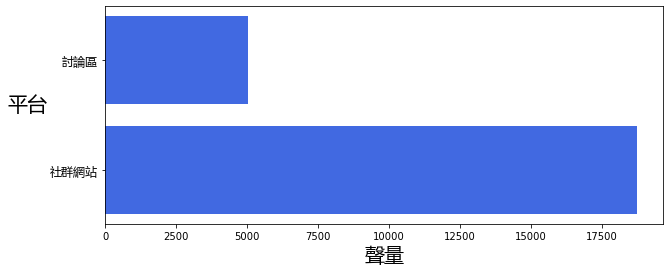

In [256]:
f,ax=plt.subplots(1,1,figsize=(10,4))
ax.barh(y=df.來源.value_counts().index, width=df.來源.value_counts().values, color="royalblue")
# 設定字體和文字大小
font = FontProperties(fname="msyh.ttf", size=12)
font_label = FontProperties(fname="msyh.ttf", size=20)
# 改變ticks字體
ax.set_yticklabels(labels=df.來源.value_counts().index,font=font)
h = ax.set_ylabel("平台",font=font_label)
h.set_rotation(0)
ax.yaxis.set_label_coords(-0.14,0.5)
ax.set_xlabel("聲量",font=font_label)
# 旋轉ylabel和設定位置
plt.show()

In [257]:
fig = ax.get_figure()
fig.savefig('C:/Users/user/Desktop/碩士後/履歷/意藍二階面試/聲量_來源.png')

In [172]:
def value_counts_trans(table):
    Index = [x for x in table.index]
    Index.reverse()
    return list(np.flip(table.values)), Index

In [176]:
df["平台"] = df.來源網站.apply(lambda x: x.split(" > ")[0])
df["頻道"] = df.來源網站.apply(lambda x: x.split(" > ")[1].replace("?",""))

In [166]:
df["平台"].value_counts()[:10]

Facebook粉絲團     11130
Instagram        4895
校園聊天-Dcard       3488
Youtube 頻道       2088
Ptt              1176
Facebook公開社團      578
UrCosme           125
zuvio 校園           98
Meteor             48
痞客邦 邦邦             33
Name: 平台, dtype: int64

In [302]:
df["來源網站"] = df["來源網站"].apply(lambda x: x.replace("?",""))

<ipython-input-275-1cda3071dec1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=y_value,font=font)


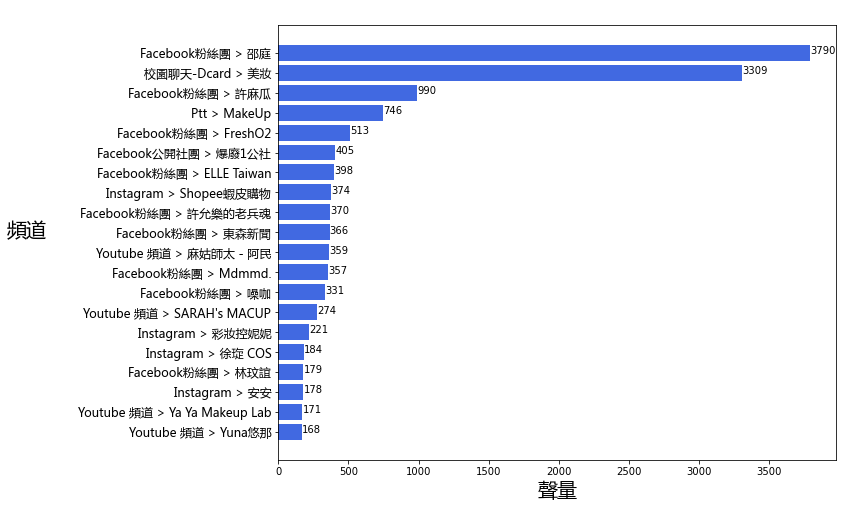

In [303]:
x_value, y_value = value_counts_trans(df["來源網站"].value_counts()[:20])
ax = plot_table(y_value,x_value," ",-0.45,"頻道")

In [304]:
fig = ax.get_figure()
fig.savefig('C:/Users/user/Desktop/碩士後/履歷/意藍二階面試/聲量_來源網站.png')

In [282]:
x_value, y_value = value_counts_trans(df["平台"].value_counts()[:10])

<ipython-input-275-1cda3071dec1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=y_value,font=font)


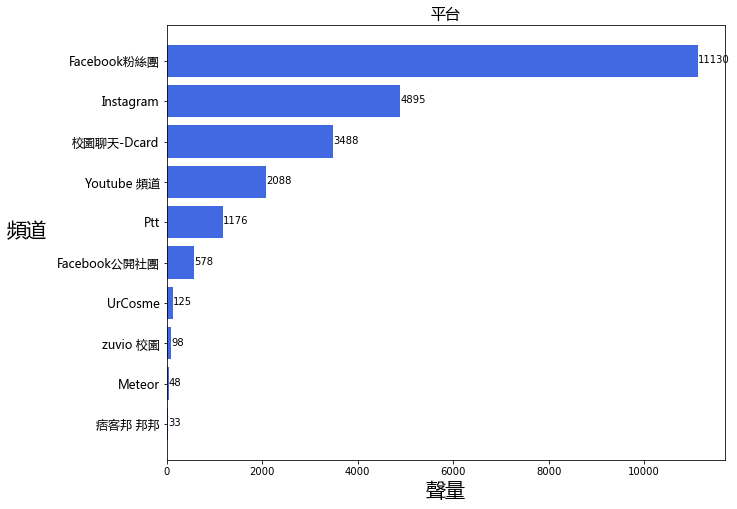

In [283]:
ax = plot_table(y_value,x_value,"平台",-0.25,"頻道")

In [284]:
fig = ax.get_figure()
fig.savefig('C:/Users/user/Desktop/碩士後/履歷/意藍二階面試/聲量_平台.png')

In [179]:
df[df["平台"]=="Facebook粉絲團"].頻道.value_counts()[:20]

邵庭                         3790
許麻瓜                         990
FreshO2                     513
ELLE Taiwan                 398
許允樂的老兵魂                     370
東森新聞                        366
Mdmmd.                      357
噪咖                          331
林玟誼                         179
樂敗精品Love Buy                164
【LOOKin】美人時髦話題網。看見女性新時尚     158
PopUlzzang 波波妝漂亮            138
靈魂有香氣的女子                    124
VOGUE Taiwan                110
韋汝                          110
Micci                        78
Beauty美人圈                    68
新聞主播 廖芳潔                     66
關於楊哲 Arger                   56
花向東                          53
Name: 頻道, dtype: int64

<ipython-input-275-1cda3071dec1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=y_value,font=font)


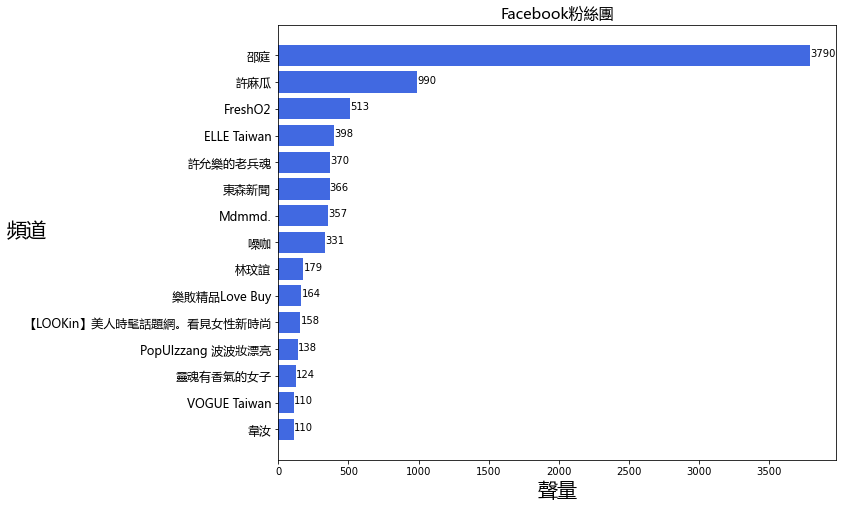

In [285]:
x_value, y_value = value_counts_trans(df[df["平台"]=="Facebook粉絲團"].頻道.value_counts()[:15])
ax = plot_table(y_value,x_value,"Facebook粉絲團",-0.45,"頻道")

In [286]:
fig = ax.get_figure()
fig.savefig('C:/Users/user/Desktop/碩士後/履歷/意藍二階面試/聲量_臉書專業.png')

In [218]:
df[df["平台"]=="Instagram"].頻道.value_counts()[:20]

Shopee蝦皮購物                374
彩妝控妮妮                     221
徐琁 COS                    184
安安                        178
MO MO                     136
詹子晴丫頭                     133
鄭 婕彤 square               124
M•A•C Cosmetics Taiwan    119
___hsun____               115
PopUlzzang 波波妝漂亮          114
M E M ♡ R Y               103
ⒶⓁⒷⒺⒺ                     103
唐葳                         99
Cindy Hsiao                98
 柔伊                        75
台灣達人秀                      75
央羊癢                        71
黃小米 Mii                    67
蔡瑞雪                        66
FreshO2                    64
Name: 頻道, dtype: int64

<ipython-input-275-1cda3071dec1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=y_value,font=font)


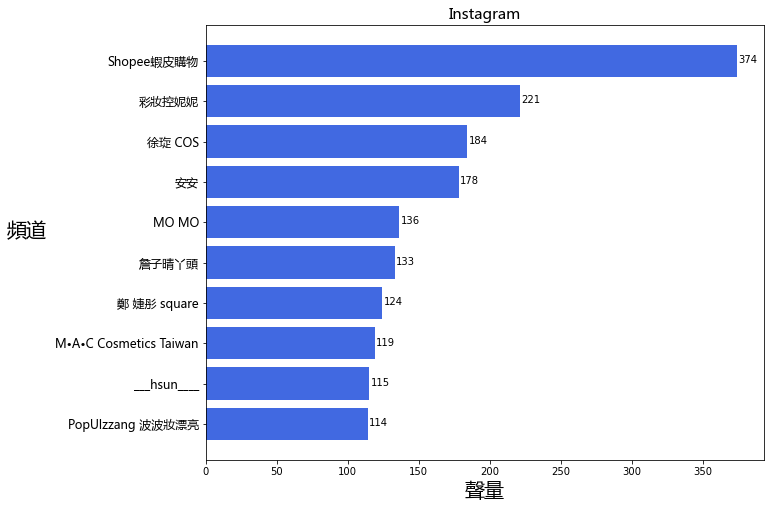

In [287]:
x_value, y_value = value_counts_trans(df[df["平台"]=="Instagram"].頻道.value_counts()[:10])
ax = plot_table(y_value,x_value,"Instagram",-0.32,"頻道")

In [288]:
fig = ax.get_figure()
fig.savefig('C:/Users/user/Desktop/碩士後/履歷/意藍二階面試/聲量_唉居.png')

<ipython-input-275-1cda3071dec1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=y_value,font=font)


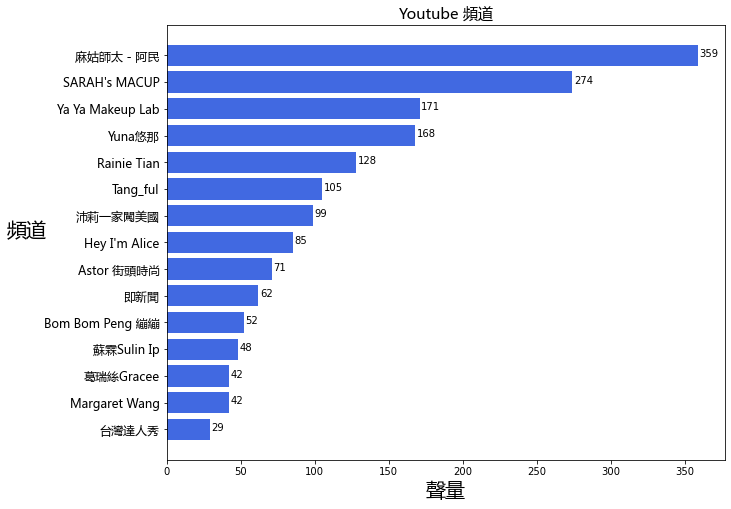

In [289]:
x_value, y_value = value_counts_trans(df[df["平台"]=="Youtube 頻道"].頻道.value_counts()[:15])
ax = plot_table(y_value,x_value,"Youtube 頻道",-0.25,"頻道")

In [290]:
fig = ax.get_figure()
fig.savefig('C:/Users/user/Desktop/碩士後/履歷/意藍二階面試/聲量_YT.png')

<ipython-input-275-1cda3071dec1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=y_value,font=font)


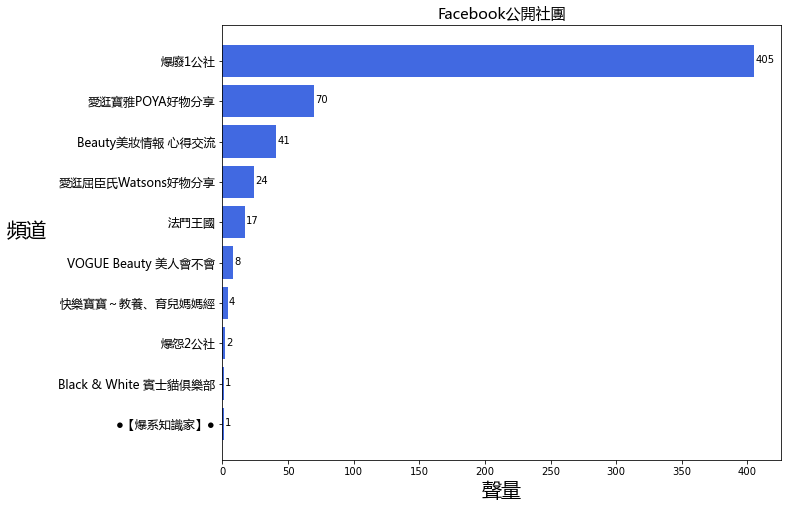

In [298]:
x_value, y_value = value_counts_trans(df[df["平台"]=="Facebook公開社團"].頻道.value_counts()[:10])
ax = plot_table(y_value,x_value,"Facebook公開社團",-0.35,"頻道")

In [299]:
fig = ax.get_figure()
fig.savefig('C:/Users/user/Desktop/碩士後/履歷/意藍二階面試/聲量_臉書社團.png')

In [184]:
df[df["平台"]=="校園聊天-Dcard"].頻道.value_counts()[:10]

美妝          3309
女孩            74
閒聊            39
網路購物          32
穿搭            13
美甲             4
YouTuber       4
省錢             4
工作             4
無痕生活           2
Name: 頻道, dtype: int64

<ipython-input-275-1cda3071dec1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=y_value,font=font)


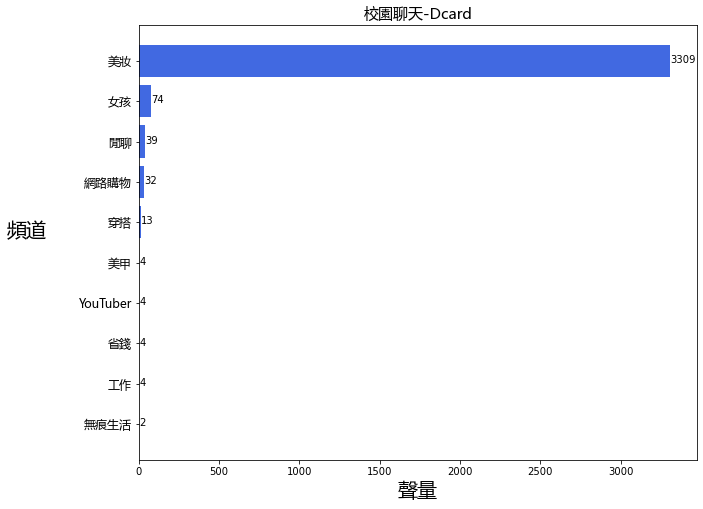

In [292]:
x_value, y_value = value_counts_trans(df[df["平台"]=="校園聊天-Dcard"].頻道.value_counts()[:10])
ax = plot_table(y_value,x_value,"校園聊天-Dcard",-0.2,"頻道")

In [293]:
fig = ax.get_figure()
fig.savefig('C:/Users/user/Desktop/碩士後/履歷/意藍二階面試/聲量_滴卡.png')

In [224]:
df[df["平台"]=="Ptt"].頻道.value_counts()[:20]

MakeUp          746
Gossiping       134
BeautyMarket    109
WomenTalk        75
KoreaDrama       45
BeautySalon      19
Wanted            9
talk              8
Beauty            7
Brand             6
HatePolitics      5
Hualien           3
ThaiDrama         2
IU                2
TurtleSoup        1
MAC               1
GirlComics        1
I-Lan             1
IZONE             1
TWICE             1
Name: 頻道, dtype: int64

<ipython-input-275-1cda3071dec1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=y_value,font=font)


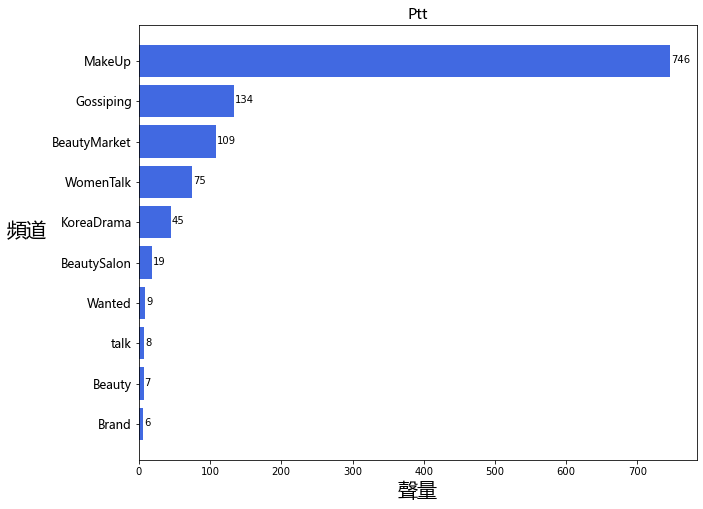

In [294]:
x_value, y_value = value_counts_trans(df[df["平台"]=="Ptt"].頻道.value_counts()[:10])
ax = plot_table(y_value,x_value,"Ptt",-0.2,"頻道")

In [295]:
fig = ax.get_figure()
fig.savefig('C:/Users/user/Desktop/碩士後/履歷/意藍二階面試/聲量_批踢踢.png')

<ipython-input-275-1cda3071dec1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=y_value,font=font)


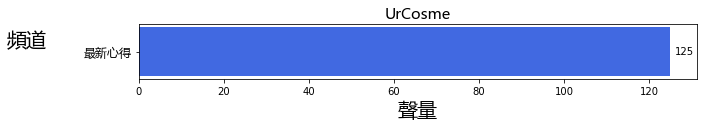

In [296]:
x_value, y_value = value_counts_trans(df[df["平台"]=="UrCosme"].頻道.value_counts())
ax = plot_table(y_value,x_value,"UrCosme",-0.2,"頻道",(10,1))

In [297]:
fig = ax.get_figure()
fig.savefig('C:/Users/user/Desktop/碩士後/履歷/意藍二階面試/聲量_UrCosme.png')

In [ ]:
# 不是每一篇討論串的主文都有包含在內
# 有不同頻道但是標題相同的文章